In [20]:
import pyreadr
import numpy as np
from pandas import DataFrame
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from collections import OrderedDict

pandas2ri.activate()
sequence_length = 50
indicator_length = 10
sequence_feature_length = 4
# added pricechange
indicator_feature_length = 9

readRDS = robjects.r['readRDS']
# 2018_2019_trainingData_50d_10d_3x.rds
# Q$_2018_2019_trainingData_50d_20d.rds

trainingDataList = readRDS('Q4_2014_2017_trainingData_50d_5d_1d_with03_macd.rds')

In [27]:

def create_inputs_and_target(
    training_data_list, 
    time_steps, 
    indicator_length, 
    n_price_features,
    n_indicator_features ):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """
    
    # w, x, y, z acceleration as features
    # Number of steps to advance in each iteration (for me, it should always
    # price time sequence
    x1_segment = []
    # indicators
    x2_segment = []
    # indicators wkly
    x3_segment = []
    # targets
    targets = []
    # changes
    changes = []
    
    for training_data in training_data_list:
        
        # generate price variables
        pd_price_df = pandas2ri.ri2py_dataframe(training_data[0])
        
        ws = pd_price_df['Open'].values
        xs = pd_price_df['High'].values
        ys = pd_price_df['Low'].values
        zs = pd_price_df['Close'].values
        
        
        # generate indicator variables
        pd_indi_df = pandas2ri.ri2py_dataframe(training_data[1])
        indi_arr = pd_indi_df.to_numpy()
        reshaped_indicators = indi_arr.flatten()
        
        # generate indicator variables wkly
        pd_indi_df_wkly = pandas2ri.ri2py_dataframe(training_data[4])
        indi_arr_wkly = pd_indi_df_wkly.to_numpy()
        reshaped_indicators_wkly = indi_arr_wkly.flatten()
        
        # Retrieve target value
        y = training_data[2][0]
        # Retrieve target value
        change = training_data[3][0]
        
        # append vectorized values to vectors
        x1_segment.append([ws, xs, ys, zs])
        x2_segment.append(reshaped_indicators)
        x3_segment.append(reshaped_indicators_wkly)
        targets.append(y)
        changes.append(change)

    # Bring the price segments into a better shape
    reshaped_x1_segment = np.asarray(x1_segment).reshape(-1, time_steps, n_price_features)
    reshaped_x2_segment = np.asarray(x2_segment)
    reshaped_x3_segment = np.asarray(x3_segment)
    targets = np.asarray(targets)
    changes = np.asarray(changes)

    return reshaped_x1_segment, reshaped_x2_segment, reshaped_x3_segment, targets, changes


In [1]:
import pandas as pd
import numpy as np

# generate model data
x1_train, x2_train, x3_train, y_train, z = create_inputs_and_target(
    trainingDataList, 
    sequence_length, 
    indicator_length, 
    sequence_feature_length,
    indicator_feature_length )

print(x1_train.shape)
print(x2_train.shape)
print(x3_train.shape)
print(y_train.shape)
print(z.shape)

NameError: name 'create_inputs_and_target' is not defined

In [14]:
# create randomized indizes 
sample_size = len(y)
threshold = int(np.ceil(sample_size*0.8))
sample_range = np.arange(sample_size)
np.random.shuffle(sample_range)
training_indizes, test_indizes = sample_range[:threshold], sample_range[threshold:]

# create randomized test and training sets
x1_train = x1[training_indizes]
x2_train = x2[training_indizes]
x3_train = x3[training_indizes]
y_train = y[training_indizes]
z_train = z[training_indizes]

x1_test = x1[test_indizes]
x2_test = x2[test_indizes]
x3_test = x3[test_indizes]
y_test = y[test_indizes]
z_test = z[test_indizes]

# check for correct dimensions
print(x1_train.shape)
print(x2_train.shape)
print(x3_train.shape)
print(x1_test.shape)
print(x2_test.shape)
print(x3_test.shape)


(18831, 50, 4)
(18831, 45)
(18831, 45)
(4707, 50, 4)
(4707, 45)
(4707, 45)


In [195]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import LSTM
from keras.models import Model
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    #model.add(Dense(256, input_dim=dim, activation="tanh"))
    #model.add(Dropout(0.5))
    #model.add(Dense(128, input_dim=dim, activation="tanh"))
    #model.add(Dropout(0.4))
    #model.add(Dense(64, input_dim=dim, activation="tanh"))
    #model.add(Dropout(0.3))
    model.add(Dense(32, input_dim=dim, activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="tanh"))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation="tanh"))
    model.add(Dense(3, activation="tanh"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="tanh"))
    # print(model.summary())
    # return our model
    return model

def create_cnn(n_days, n_features, filters, kernel_size, regress=False):
    
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(n_days,n_features)))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Flatten())
    # if (n_days == 50):
    model.add(Dense(36, activation='tanh'))
    # if (n_days == 60):
     #   model.add(Dense(44, activation='tanh'))
    # if (n_days == 100):
     #   model.add(Dense(75, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='tanh'))
    if regress:
        model.add(Dense(1, activation="tanh"))
    #print(model.summary())
    # return the CNN
    return model

def create_lstm(n_days, n_features,  regress=False):
    model = Sequential()
    model.add(LSTM(4, return_sequences=False, dropout_U = 0.1, dropout_W = 0.1, input_shape=(n_days,n_features)))
    model.add(Dense(3, activation='tanh'))
    if regress:
        model.add(Dense(1, activation="tanh"))
    return model


In [6]:
# import the necessary packages
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate
import numpy as np
import argparse
import locale
import os

# create the MLP and CNN models
mlp = create_mlp(x2_train.shape[1], regress=False)
mlp_wkly = create_mlp(x3_train.shape[1], regress=False)
cnn = create_cnn(x1_train.shape[1], x1_train.shape[2], 32 , 3, regress=False)
lstm = create_lstm(x1_train.shape[1], x1_train.shape[2], regress=True)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([cnn.output, mlp.output, mlp_wkly.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(9, activation="tanh")(combinedInput)
x = Dense(3, activation="tanh")(x)
x = Dense(1, activation="tanh")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
#print(model.summary())
# mean_absolute_percentage_error funtioniert nur mit adam
# mean_squared_error
# sgd
# adam
# opt = Adam(lr=5e-4)

model = Model(inputs=[cnn.input, mlp.input, mlp_wkly.input], outputs=x)

#print(model.summary())
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

print("[INFO] training model...")
# optimal range between 80 and 120 around loss: 0.9095
history = model.fit(
            [x1_train, x2_train, x3_train], y_train,
            validation_data=([x1_test, x2_test, x3_test], y_test),
            epochs=15, batch_size=8)

ModuleNotFoundError: No module named 'keras'

In [230]:
history = model.fit(
            [x1_train, x2_train, x3_train], y_train,
            validation_data=([x1_test, x2_test, x3_test], y_test),
            epochs=1, batch_size=8)

Train on 23538 samples, validate on 7141 samples
Epoch 1/1
23538/23538 [==============================] - 40s 2ms/step - loss: 0.1386 - accuracy: 0.8587 - val_loss: 0.9953 - val_accuracy: 0.0000e+00


In [ ]:
# check model
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict([x1_test, x2_test, x3_test])

predictions = predictions.flatten()
actual_changes = y_test
ann_results = np.multiply(predictions, actual_changes)

Y = np.arange(len(actual_changes))

print('---ANN output---')
fig = plt.figure()
ax = plt.subplot(111)
ax.bar(Y, predictions, width=1, color='b')

print('---correct/incorrect---')
#fig = plt.figure()
#ax = plt.subplot(111)
#ax.bar(Y, ann_results, width=1, color='b')


print('---samplesize---')
samplesize = len(predictions)
print(samplesize)
#
print('---numberOfBest---')
indizesOfBest = np.argwhere(ann_results > 0.1)
print(len(indizesOfBest))
print('---numberOfGood---')
indizesOfGood = np.argwhere(ann_results > 0.0)
print(len(indizesOfGood))
print('---numberOfBad---')
indizesOfBad = np.argwhere(ann_results < 0.0)
print(len(indizesOfBad))
print('---numberOfStrongBuySignals---')
indizesOfStrongBuySignal = predictions.argsort()[-16:][::-1]
print(len(indizesOfStrongBuySignal))
print('---numberOfStrongSellSignals---')
indizesOfStrongSellSignal = (-predictions).argsort()[-16:][::-1]
print(len(indizesOfStrongSellSignal))


ceilArray = np.ceil(ann_results)
floorArray = np.floor(ann_results)
correct = sum(ceilArray)
incorrect = abs(sum(floorArray))
print('---incorrect/correct---')
print(incorrect/correct)
print('---correct---')
print(correct/samplesize)
print('---incorrect---')
print(incorrect/samplesize)

correct_trades = 0
moving_trades = 0

print('---Strong Buy Signal incorrect/correct---')
tmp = z_test[indizesOfStrongBuySignal]
ceilArray = np.argwhere(tmp > 0.0)
floorArray = np.argwhere(tmp < 0.0)
nomoveArray = np.argwhere(tmp == 0.0)
correct = len(ceilArray)
incorrect = abs(len(floorArray))
neutral = abs(len(nomoveArray))
correct_trades = correct_trades + correct
moving_trades = moving_trades + correct + incorrect
print('---Strong Buy Signal correct---')
print(correct/len(tmp))
print('---Strong Buy Signal incorrect---')
print(incorrect/len(tmp))
print('---Strong Buy Signal neutral---')
print(neutral/len(tmp))
print('---Profit in percent---')
print(sum(z_test[indizesOfStrongBuySignal]))


print('---Strong Short Signal incorrect/correct---')
tmp = z_test[indizesOfStrongSellSignal]
ceilArray = np.argwhere(tmp > 0.0)
floorArray = np.argwhere(tmp < 0.0)
nomoveArray = np.argwhere(tmp == 0.0)
correct = abs(len(floorArray))
incorrect = len(ceilArray)
neutral = abs(len(nomoveArray))
correct_trades = correct_trades + correct
moving_trades = moving_trades + correct + incorrect
print('---Strong Short Signal correct---')
print(correct/len(tmp))
print('---Strong Short Signal incorrect---')
print(incorrect/len(tmp))
print('---Strong Short Signal neutral---')
print(neutral/len(tmp))
print('---Profit in percent---')
print(-sum(z_test[indizesOfStrongSellSignal]))


print('---Sum of all changes---')
print(sum(z_test))
print('---Buy signal times Change---')
print(sum(np.multiply(z_test[indizesOfStrongBuySignal], predictions[indizesOfStrongBuySignal])))
print('---Sell signal times Change---')
print(sum(np.multiply(z_test[indizesOfStrongSellSignal], predictions[indizesOfStrongSellSignal])))
print('---correct/incorrect trades---')
print(correct_trades/moving_trades)

---ANN output---
---correct/incorrect---
---samplesize---
7141
---numberOfBest---
65
---numberOfGood---
3839
---numberOfBad---
3302
---numberOfStrongBuySignals---
16
---numberOfStrongSellSignals---
16
---incorrect/correct---
0.8601198228705392
---correct---
0.5375997759417449
---incorrect---
0.46240022405825515
---Strong Buy Signal incorrect/correct---
---Strong Buy Signal correct---
0.5
---Strong Buy Signal incorrect---
0.375
---Strong Buy Signal neutral---
0.125
---Profit in percent---
0.029037523095451045
---Strong Short Signal incorrect/correct---
---Strong Short Signal correct---
0.8125
---Strong Short Signal incorrect---
0.125
---Strong Short Signal neutral---
0.0625
---Profit in percent---
0.7550647075196206
---Sum of all changes---
11.530357718799529
---Buy signal times Change---
0.0017331851215888362
---Sell signal times Change---
0.39069186552373203
---correct/incorrect trades---
0.7241379310344828


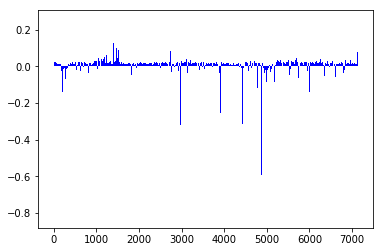

In [254]:
from matplotlib import pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xscale('log')
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


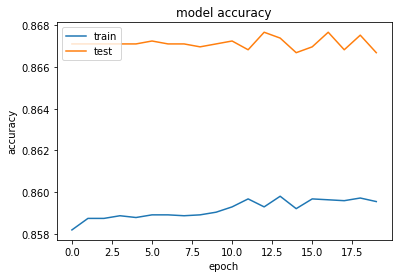

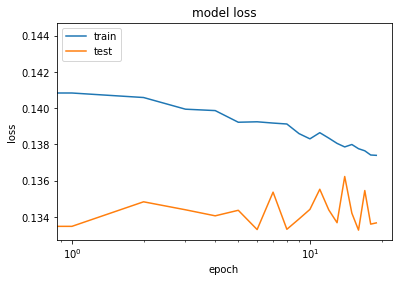

In [65]:
from tensorflow import keras
# Save the model
model.save('MLP_CNN_02.h5')

# Recreate the exact same model purely from the file
new_model = keras.models.load_model('MLP_CNN_02.h5', compile=False)

In [109]:
import pyreadr
import numpy as np
import rpy2.robjects as robjects
import pandas as pd
import numpy as np
from rpy2.robjects import pandas2ri
from pandas import DataFrame
from collections import OrderedDict

#----------------Import R Data-------------------#
pandas2ri.activate()
sequence_length = 50
indicator_length = 10
sequence_feature_length = 4
# added pricechange
indicator_feature_length = 9

readRDS = robjects.r['readRDS']
# 2018_2019_trainingData_50d_10d_3x.rds
# Q$_2018_2019_trainingData_50d_20d.rds
#

trainingDataList = readRDS('Q4_2019_trainingData_50d_5d_1d_no0_macd.rds')


#----------------Convert R Data in Training Data-------------------#


# generate model data
x1_test, x2_test, x3_test, y_test, z_test = create_inputs_and_target(
    trainingDataList, 
    sequence_length, 
    indicator_length, 
    sequence_feature_length,
    indicator_feature_length )

print(x1_test.shape)
print(x2_test.shape)
print(x3_test.shape)
print(y_test.shape)
print(z_test.shape)


/Users/rhanelt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


(7141, 50, 4)
(7141, 45)
(7141, 45)
(7141,)
(7141,)
